## Time Series Regression


In [1]:
# version 1.5
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myBasic.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myPreprocessing.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myTSRegression.R")

## Dataset for exploring
Some parameters are fixed but can be explored. 
TSNormalization used is ts_gminmax(), but other normalizations are available.

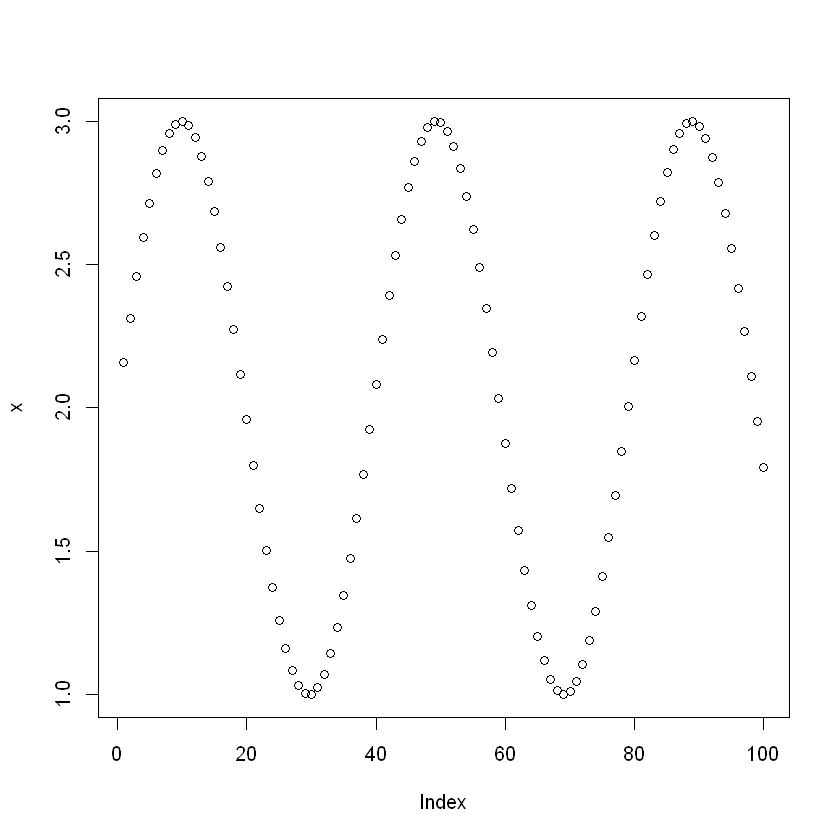

In [2]:
load_series <- function(name) {
  link <- url(sprintf("https://raw.githubusercontent.com/eogasawara/mylibrary/master/data/time-series/%s.RData", name))
  x <- get(load(link))
  return(x)  
}
x <- load_series("sin")
sahead <- 1
tsize <- 1
swsize <- 10
preproc <- ts_gminmax()
plot(x)


## General function for testing regression methods

In [3]:
train_test <- function(x, model, sw_size, test_size, steps_ahead) {
  ts <- ts_data(x, sw_size)
  
  samp <- ts_sample(ts, test_size)
  
  io_train <- ts_projection(samp$train)
  
  model <- fit(model, x=io_train$input, y=io_train$output)
  
  adjust <- predict(model, io_train$input)
  ev_adjust <- evaluation.tsreg(io_train$output, adjust)
  print(head(ev_adjust$metrics))
  
  io_test <- ts_projection(samp$test)
  
  prediction <- predict(model, x=io_test$input, steps_ahead=steps_ahead)
  output <- as.vector(io_test$output)
  if (steps_ahead > 1)
    output <- output[1:steps_ahead]
  ev_prediction <- evaluation.tsreg(output, prediction)
  print(head(ev_prediction$metrics))
  
  prep <- ""
  if (!is.null(model$preprocess))
    prep <- sprintf("-%s", class(model$preprocess)[1])    
  
  print(sprintf("%s%s %.2f", class(model)[1], prep, 100*ev_prediction$metrics$smape))
  
  yvalues <- c(io_train$output, io_test$output)
  plot(model, y=yvalues, yadj=adjust, ypre=prediction)
  return(model)
}

## ARIMA (baseline)

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

tsreg_arima,fit.tsreg_arima,0.076,



        mse      smape
1 0.0123684 0.05188252
        mse      smape
1 0.0257263 0.08558225
[1] "tsreg_arima 8.56"


Loading required package: TSPred


Attaching package: 'TSPred'


The following object is masked _by_ '.GlobalEnv':

    minmax


The following object is masked from 'package:base':

    subset




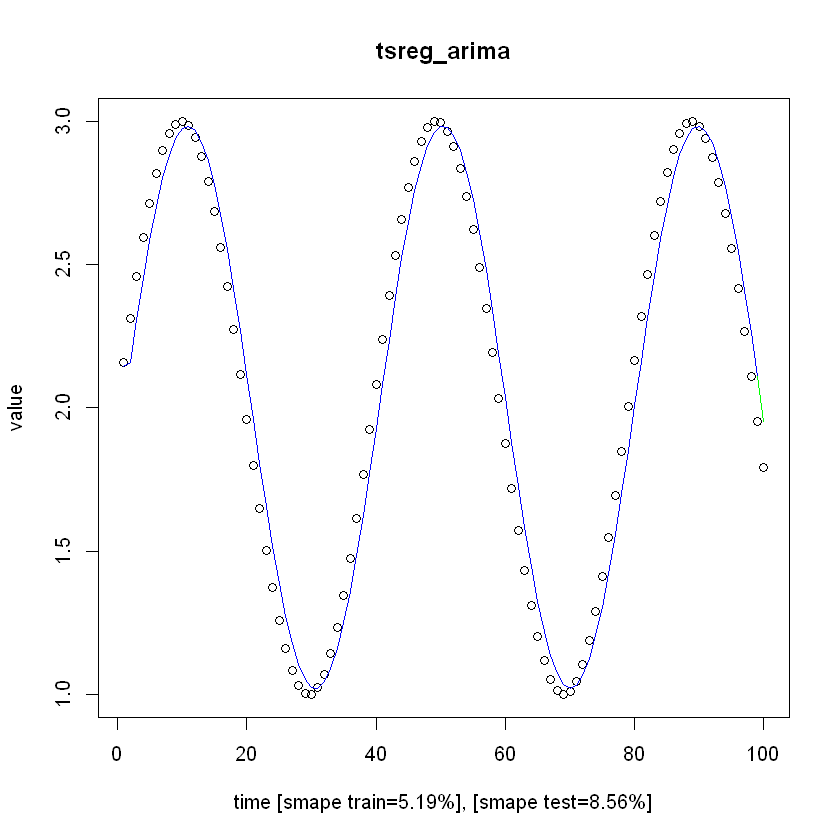

In [4]:
model <- train_test(x, model=tsreg_arima(), 0, 
           test_size = tsize, steps_ahead = sahead)

## Random Forest

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message in rfout$mse/(var(y) * (n - 1)/n):
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
tsreg_rf,fit.tsreg_sw,0.006,mtry=3,ntree=50



         mse      smape
1 0.00217001 0.02093969
          mse      smape
1 0.005588891 0.04082207
[1] "tsreg_rf-ts_gminmax 4.08"


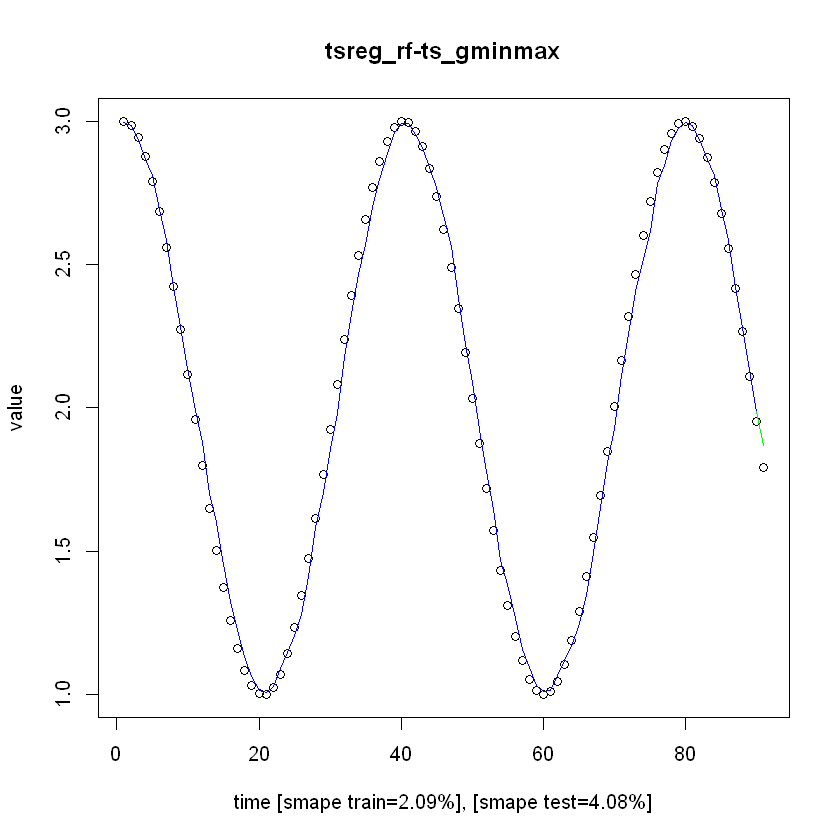

In [5]:
# do not set mtry and ntree for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_rf(preproc, input_size=4, mtry=3, ntree=50), 
                    sw = swsize, test_size = tsize, steps_ahead = sahead)

## Neural Networks - MLP

Loading required package: nnet

tsreg_mlp,fit.tsreg_sw,0.001,size=4,decay=0.00



           mse       smape
1 4.142749e-06 0.001087659
           mse       smape
1 4.907576e-06 0.001235635
[1] "tsreg_mlp-ts_gminmax 0.12"


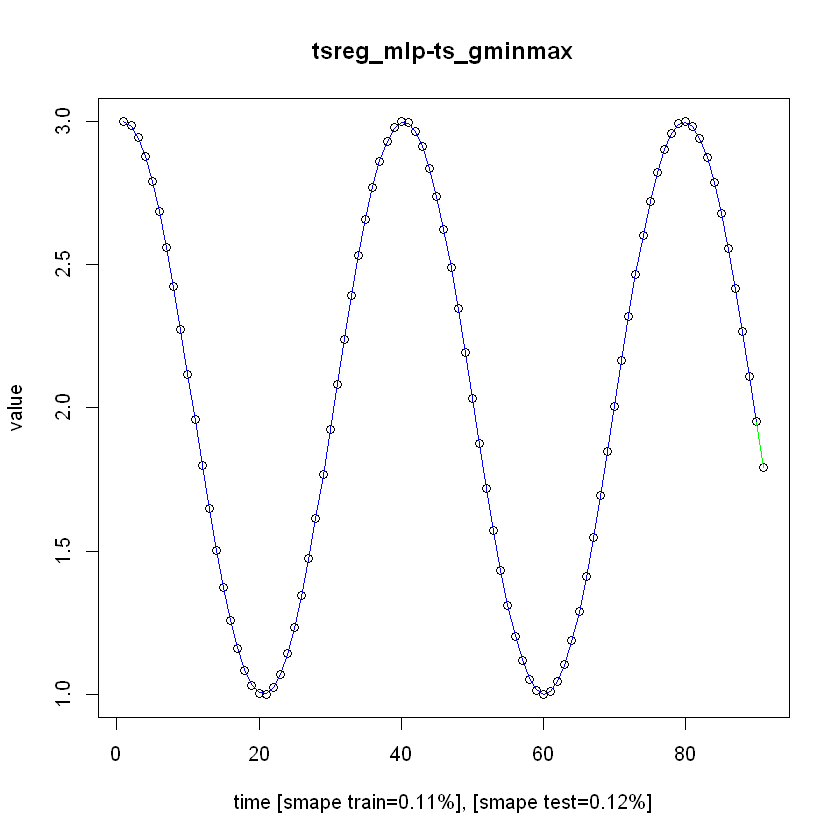

In [6]:
# do not set decay and set a range for neurons for hyperparameter optimization
# you can also set a range for them
  model <- train_test(x, model=tsreg_mlp(preproc, input_size=4, size=4, decay=0), 
             sw = swsize, test_size = tsize, steps_ahead = sahead)

## SVM


Loading required package: e1071

tsreg_svm,fit.tsreg_sw,0.011,epsilon=0.0,cost=80.000



           mse        smape
1 2.954775e-08 7.680232e-05
          mse        smape
1 7.28081e-08 0.0001504218
[1] "tsreg_svm-ts_gminmax 0.02"


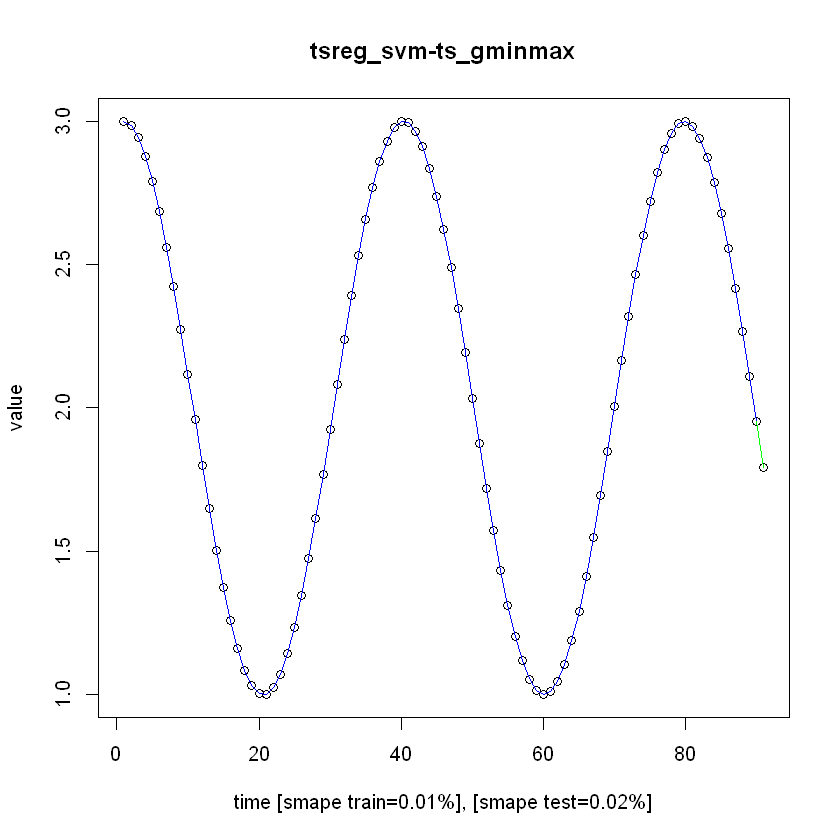

In [7]:
#do not set epsilon, cost, and  kernel for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_svm(preproc, input_size=4, epsilon=0.0, cost=80.00), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## ELM

Loading required package: elmNNRcpp

Loading required package: KernelKnn

tsreg_elm,fit.tsreg_sw,0.009,nhid=3,actfun=purelin



           mse        smape
1 2.551746e-29 1.769572e-15
           mse        smape
1 5.369185e-29 4.084534e-15
[1] "tsreg_elm-ts_gminmax 0.00"


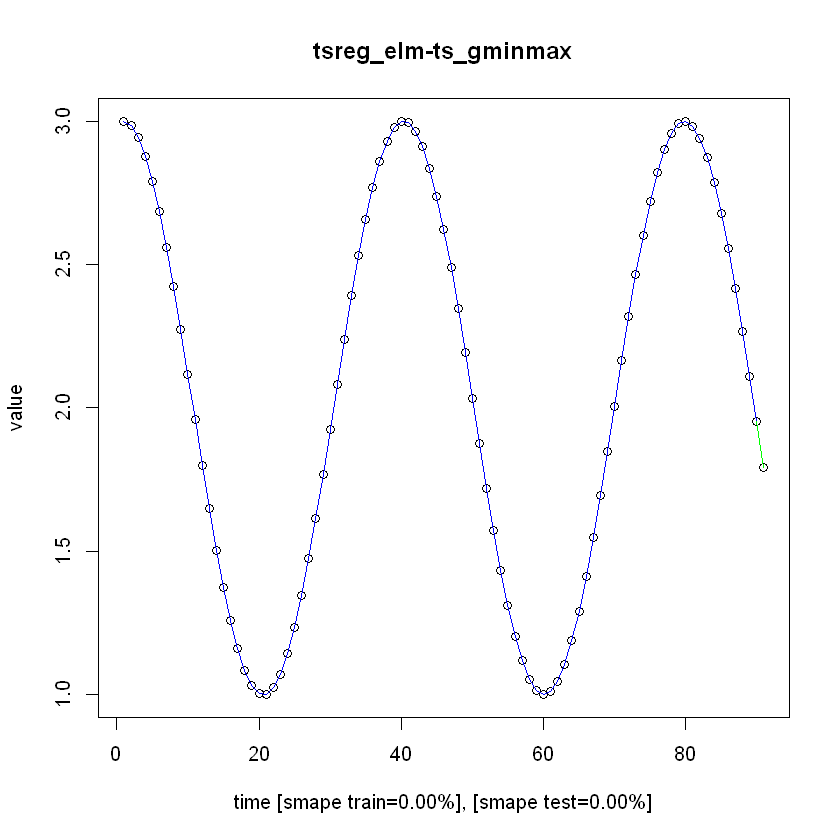

In [8]:
#do not set nhid and actfun for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_elm(preproc, input_size=4, nhid=3,actfun="purelin"), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## Convolutional neural networks (CNN)

Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: tfdatasets


Attaching package: 'tfdatasets'


The following object is masked _by_ '.GlobalEnv':

    fit


Loading required package: tensorflow


Attaching package: 'tensorflow'


The following objects are masked from 'package:TSPred':

    evaluate, train


Loading required package: keras


Attaching package: 'keras'


The following objects are masked _by_ '.GlobalEnv':

    fit, normalize


The following object is masked from 'package:TSPred':

    evaluate


tsreg_cnn,fit.tsreg_sw,1.054,neurons=16,epochs=200



          mse      smape
1 0.001947955 0.02268179
           mse       smape
1 5.108397e-06 0.001260678
[1] "tsreg_cnn-ts_gminmax 0.13"


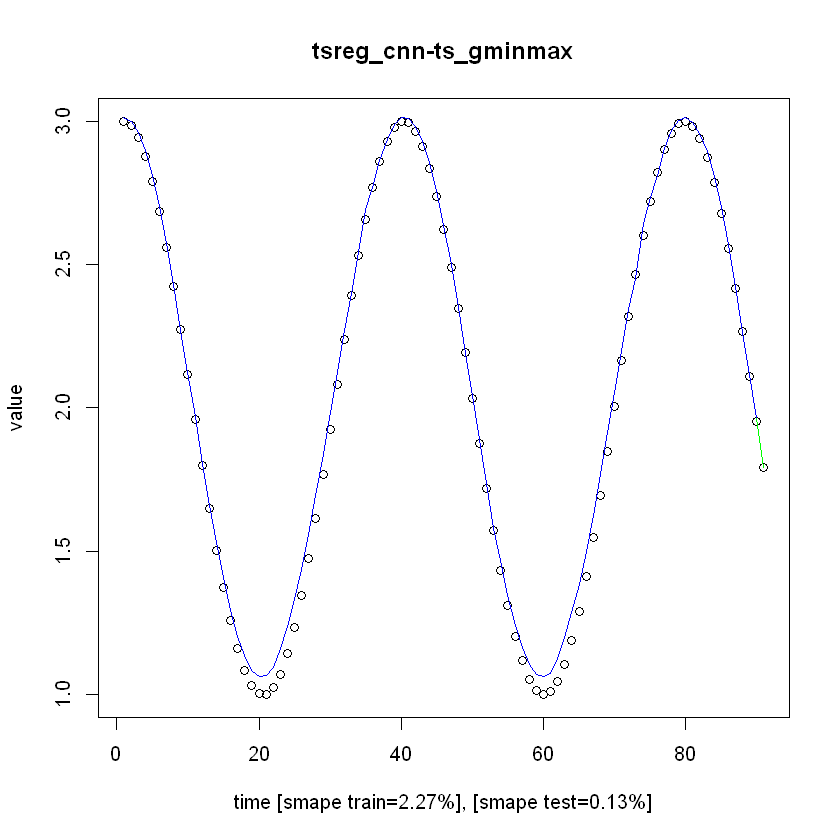

In [9]:
# do not set neurons and epochs for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_cnn(preproc, input_size=4, neurons=16,epochs=200), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## Long short-term memory (LSTM)

tsreg_lstm,fit.tsreg_sw,1.715,neurons=32,epochs=200



          mse      smape
1 0.008717085 0.04695401
         mse      smape
1 0.00189215 0.02454503
[1] "tsreg_lstm-ts_gminmax 2.45"


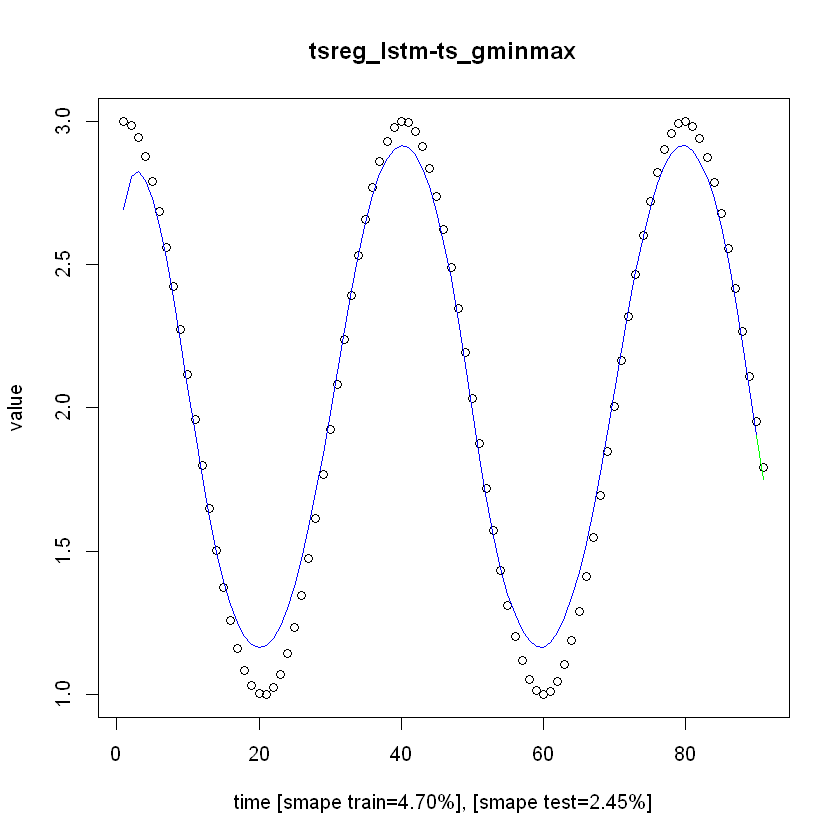

In [10]:
# do not set neurons and epochs for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_lstm(preproc, input_size=4, neurons=32, epochs=200), 
                    sw = swsize, test_size = tsize, steps_ahead = sahead)